In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pydicom
import cv2

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("📌 GPU devices:", tf.config.list_physical_devices('GPU'))


2025-06-28 12:05:35.757972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751112335.973804      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751112336.032562      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


📌 GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
DICOM_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"
LABELS_PATH = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
PNG_DIR = "/kaggle/working/rsna_png"
os.makedirs(PNG_DIR, exist_ok=True)

df = pd.read_csv(LABELS_PATH).drop_duplicates("patientId")
for pid in tqdm(df['patientId']):
    dcm_path = os.path.join(DICOM_DIR, pid + ".dcm")
    png_path = os.path.join(PNG_DIR, pid + ".png")

    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255.0
    img = cv2.resize(img.astype(np.uint8), (299, 299))
    cv2.imwrite(png_path, img)


100%|██████████| 26684/26684 [08:19<00:00, 53.43it/s]


In [3]:
df['filename'] = df['patientId'] + ".png"
df['Target'] = df['Target'].astype(str)

train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Target'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df['Target'], random_state=42)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


Train: 19212 Val: 2135 Test: 5337


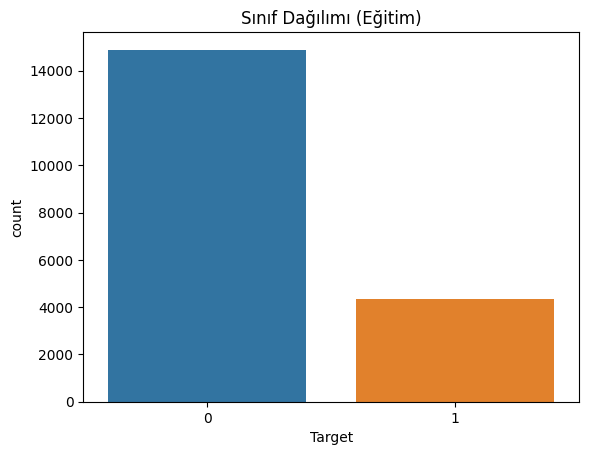

In [4]:
sns.countplot(data=train_df, x='Target')
plt.title("Sınıf Dağılımı (Eğitim)")
plt.show()


In [5]:
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(train_df['Target']),
                                            y=train_df['Target'])
class_weights = dict(zip(np.unique(train_df['Target']), weights))
print("Class Weights:", class_weights)


Class Weights: {'0': 0.6454343882281798, '1': 2.218988218988219}


In [6]:
BATCH_SIZE = 32
IMG_SIZE = 299

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(train_df, PNG_DIR, x_col='filename', y_col='Target',
                                              target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary',
                                              batch_size=BATCH_SIZE)

val_gen = val_test_datagen.flow_from_dataframe(val_df, PNG_DIR, x_col='filename', y_col='Target',
                                               target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary',
                                               batch_size=BATCH_SIZE, shuffle=False)

test_gen = val_test_datagen.flow_from_dataframe(test_df, PNG_DIR, x_col='filename', y_col='Target',
                                                target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary',
                                                batch_size=BATCH_SIZE, shuffle=False)


Found 19212 validated image filenames belonging to 2 classes.
Found 2135 validated image filenames belonging to 2 classes.
Found 5337 validated image filenames belonging to 2 classes.


In [7]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Sadece dense katmanları eğit

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1751112848.067367      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,327,585 (85.17 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [8]:
callbacks = [
    ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)
]

history = model.fit(train_gen, validation_data=val_gen,
                    epochs=10, class_weight=class_weights,
                    callbacks=callbacks)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1751112869.702948     102 service.cc:148] XLA service 0x7a0a384597c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751112869.703730     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751112871.649110     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/601 ━━━━━━━━━━━━━━━━━━━━ 47s 79ms/step - accuracy: 0.4766 - loss: 1.5962   

I0000 00:00:1751112880.095270     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.7683 - loss: 0.7840
Epoch 1: val_loss improved from inf to 0.48140, saving model to best_model.h5
601/601 ━━━━━━━━━━━━━━━━━━━━ 424s 669ms/step - accuracy: 0.7683 - loss: 0.7837 - val_accuracy: 0.8112 - val_loss: 0.4814 - learning_rate: 0.0010
Epoch 2/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.7883 - loss: 0.5043
Epoch 2: val_loss improved from 0.48140 to 0.43889, saving model to best_model.h5
601/601 ━━━━━━━━━━━━━━━━━━━━ 387s 643ms/step - accuracy: 0.7883 - loss: 0.5042 - val_accuracy: 0.8145 - val_loss: 0.4389 - learning_rate: 0.0010
Epoch 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.7957 - loss: 0.4686
Epoch 3: val_loss did not improve from 0.43889
601/601 ━━━━━━━━━━━━━━━━━━━━ 382s 635ms/step - accuracy: 0.7957 - loss: 0.4686 - val_accuracy: 0.7920 - val_loss: 0.4396 - learning_rate: 0.0010
Epoch 4/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.7976 - loss: 0.4550
Epoch 4: val_loss

In [9]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy', metrics=['accuracy'])

fine_history = model.fit(train_gen, validation_data=val_gen,
                         epochs=10, class_weight=class_weights,
                         callbacks=callbacks)


Epoch 1/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.8071 - loss: 0.4452
Epoch 1: val_loss improved from 0.40721 to 0.39810, saving model to best_model.h5
601/601 ━━━━━━━━━━━━━━━━━━━━ 466s 725ms/step - accuracy: 0.8071 - loss: 0.4452 - val_accuracy: 0.8239 - val_loss: 0.3981 - learning_rate: 1.0000e-05
Epoch 2/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.8143 - loss: 0.4234
Epoch 2: val_loss improved from 0.39810 to 0.38727, saving model to best_model.h5
601/601 ━━━━━━━━━━━━━━━━━━━━ 416s 692ms/step - accuracy: 0.8143 - loss: 0.4234 - val_accuracy: 0.8347 - val_loss: 0.3873 - learning_rate: 1.0000e-05
Epoch 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.8188 - loss: 0.4115
Epoch 3: val_loss improved from 0.38727 to 0.38145, saving model to best_model.h5
601/601 ━━━━━━━━━━━━━━━━━━━━ 404s 672ms/step - accuracy: 0.8188 - loss: 0.4115 - val_accuracy: 0.8398 - val_loss: 0.3814 - learning_rate: 1.0000e-05
Epoch 4/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 

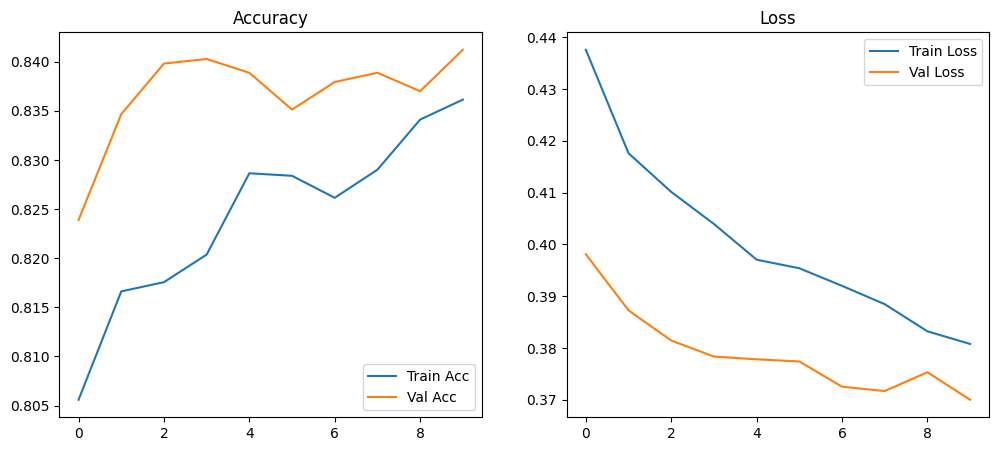

In [10]:
def plot_history(h):
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='Train Acc')
    plt.plot(h.history['val_accuracy'], label='Val Acc')
    plt.legend(); plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='Train Loss')
    plt.plot(h.history['val_loss'], label='Val Loss')
    plt.legend(); plt.title("Loss")

plot_history(fine_history)


167/167 ━━━━━━━━━━━━━━━━━━━━ 38s 186ms/step
ROC AUC: 0.8630565341520682
              precision    recall  f1-score   support

           0       0.85      0.94      0.90      4135
           1       0.69      0.44      0.54      1202

    accuracy                           0.83      5337
   macro avg       0.77      0.69      0.72      5337
weighted avg       0.82      0.83      0.81      5337



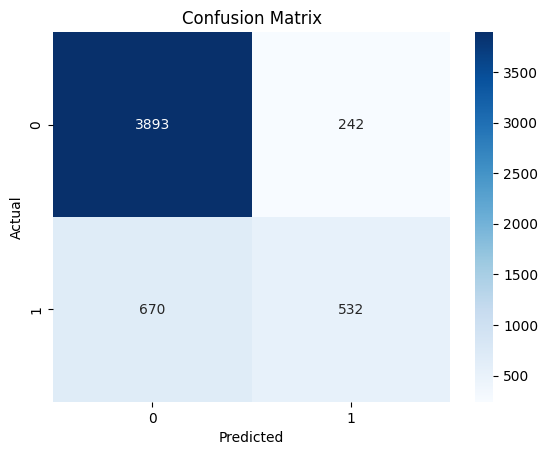

In [11]:
model.load_weights("best_model.h5")
y_true = test_gen.classes
y_prob = model.predict(test_gen).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_true, y_prob))
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


167/167 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step
🔹 Accuracy      : 0.8291
🔹 Precision     : 0.6873
🔹 Recall        : 0.4426
🔹 F1-Score      : 0.5385
🔹 ROC AUC Score : 0.8631

              precision    recall  f1-score   support

      Normal       0.85      0.94      0.90      4135
   Pneumonia       0.69      0.44      0.54      1202

    accuracy                           0.83      5337
   macro avg       0.77      0.69      0.72      5337
weighted avg       0.82      0.83      0.81      5337



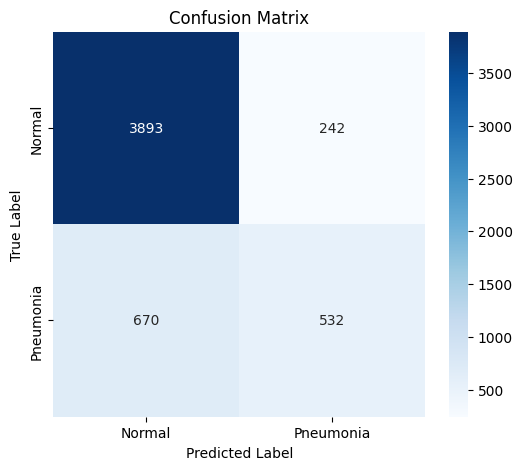

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Tahminler
model.load_weights("best_model.h5")
y_true = test_gen.classes
y_probs = model.predict(test_gen).ravel()
y_pred = (y_probs > 0.5).astype(int)

# Metrikler
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_probs)

print(f"🔹 Accuracy      : {acc:.4f}")
print(f"🔹 Precision     : {prec:.4f}")
print(f"🔹 Recall        : {rec:.4f}")
print(f"🔹 F1-Score      : {f1:.4f}")
print(f"🔹 ROC AUC Score : {auc:.4f}\n")

# Rapor
print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
